<a href="https://colab.research.google.com/github/RanveerVaru/Transfer_Learning_Work/blob/main/TransferLearnoing_Dog_Breed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d 'mohamedchahed/dog-breeds'

Dataset URL: https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
License(s): CC0-1.0


In [10]:
!unzip dog-breeds.zip

Archive:  dog-breeds.zip
  inflating: dog-breeds/beagle/beagle1.jpg  
  inflating: dog-breeds/beagle/beagle10.jpg  
  inflating: dog-breeds/beagle/beagle101.jpg  
  inflating: dog-breeds/beagle/beagle105.jpg  
  inflating: dog-breeds/beagle/beagle106.jpg  
  inflating: dog-breeds/beagle/beagle108.jpg  
  inflating: dog-breeds/beagle/beagle109.jpg  
  inflating: dog-breeds/beagle/beagle11.jpg  
  inflating: dog-breeds/beagle/beagle110.jpg  
  inflating: dog-breeds/beagle/beagle112.jpg  
  inflating: dog-breeds/beagle/beagle114.jpg  
  inflating: dog-breeds/beagle/beagle115.jpg  
  inflating: dog-breeds/beagle/beagle116.jpg  
  inflating: dog-breeds/beagle/beagle118.jpg  
  inflating: dog-breeds/beagle/beagle12.jpg  
  inflating: dog-breeds/beagle/beagle13.jpg  
  inflating: dog-breeds/beagle/beagle14.jpg  
  inflating: dog-breeds/beagle/beagle15.jpg  
  inflating: dog-breeds/beagle/beagle16.jpg  
  inflating: dog-breeds/beagle/beagle17.jpg  
  inflating: dog-breeds/beagle/beagle18.jpg  

In [11]:
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [12]:
#data augmentation - generating more data from existing data by pliting it , rotating image etc
# Creating ImageDataGenerator instance to Augument,split and then pass our images to the model
data_gen = ImageDataGenerator(rescale = 1./255 ,
                              width_shift_range = 0.2 ,
                              validation_split=0.1,
                              height_shift_range = 0.2 ,
                              shear_range = 0.2 ,
                              horizontal_flip = True ,
                              vertical_flip = True,
                              zoom_range = 0.2)

In [14]:
# Creating our test and validation data generator to flow images to network from images directory
#The flow_from_directory() method is used to load and augment images directly from a directory structure. It automatically labels images based on the subfolder names.
#Resizes all images to 224x224 pixels before feeding them to the model. 1080*1089 -> 224*224
#'categorical': Returns one-hot encoded labels for multi-class classification.,'binary': Returns labels as 0s and 1s (for binary classification).'sparse': Returns integer labels instead of one-hot encoding.None: No labels (for unsupervised learning).
training_data = data_gen.flow_from_directory('/content/dog-breeds',
                                            target_size = (224,224),
                                            class_mode='categorical',
                                            subset = 'training'
                                            )
validation_data = data_gen.flow_from_directory('/content/dog-breeds',
                                              target_size = (224,224),
                                              class_mode='categorical',
                                              subset = 'validation')

Found 490 images belonging to 8 classes.
Found 51 images belonging to 8 classes.


In [15]:

# Downloading the pre-trained weights.
#No top means it excludes the fully connected layer it uses for classification.We only need convolution layers.
# In Colab or Kaggle Notebook use the following
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O //content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-03-27 06:13:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘//content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

//content/sample_da 100%[===================>]  83.84M   162MB/s    in 0.5s    

2025-03-27 06:13:24 (162 MB/s) - ‘//content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
# As said before we don't want to re-train model's convolutional layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [18]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [20]:
for layer in pre_trained_model.layers:
    print(layer.name , layer.trainable)

input_layer False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
acti

In [22]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation & pass x as i/p
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                        # This Has Regularization effects
# Add a final sigmoid layer for classification
x = layers.Dense(8, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 122,230,696 (466.27 MB)

 Trainable params: 113,255,432 (432.04 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [24]:
# define the set of callbacks to be passed to the model during training
# defining our scheduler
def step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initial_alpha = 0.01
    factor = 0.5
    drop_every_epoch = 5
    # compute learning rate for the current epoch
    alpha = initial_alpha * (factor ** np.floor((1+epoch) / drop_every_epoch))
    # return the learning rate
    return float(alpha)

callbacks = [LearningRateScheduler(step_decay)]

# initialize optimizer and model
print("[INFO] compiling model...")

opt = SGD(learning_rate=0.01,momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

[INFO] compiling model...


In [25]:
history = model.fit(
    training_data,         # Training dataset
    validation_data = validation_data,  # Validation dataset
    epochs = 20,           # Number of iterations over the dataset
    callbacks = callbacks, # Learning rate scheduler (adjusts learning rate dynamically)
    verbose = 1            # Shows training progress
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1503 - loss: 3.8798 - val_accuracy: 0.3529 - val_loss: 1.8860 - learning_rate: 0.0100
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 723ms/step - accuracy: 0.3975 - loss: 1.7149 - val_accuracy: 0.6471 - val_loss: 1.1300 - learning_rate: 0.0100
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.6482 - loss: 1.0612 - val_accuracy: 0.7059 - val_loss: 0.8091 - learning_rate: 0.0100
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 722ms/step - accuracy: 0.7243 - loss: 0.7726 - val_accuracy: 0.8235 - val_loss: 0.5791 - learning_rate: 0.0100
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.8060 - loss: 0.5586 - val_accuracy: 0.8627 - val_loss: 0.4841 - learning_rate: 0.0050
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.8421 - loss: 0.4278 - val_accuracy: 0.8824 - val_loss: 0.4384 - learning_rate: 0.0050
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.8845 - loss: 0.382

In [26]:
#har ek epoch pr callback function chlega vo , 0.01 -> 0.005 ->0.00125

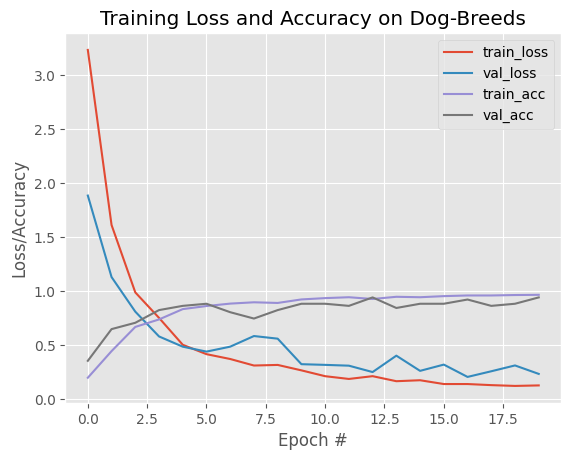

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dog-Breeds")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [30]:
model.save('/content/drive/MyDrive/fine_tuned_inception.h5')

In [31]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/fine_tuned_inception.h5')

In [34]:
from tensorflow.keras.preprocessing import image

def predict_and_display(model, class_labels, img_path, true_class=None):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img) # eg : img_array.shape = Example: (224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0) # => Output: (1, 224, 224, 3) extra 1 represent batch size, because Deep learning models expect batch input, even for a single image.
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions) #gave idx of max val
    confidence_level = np.max(predictions) #gave max val not idx

    # Decode the predicted class
    predicted_class_name = class_labels[predicted_class]

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Display the predicted class and confidence level
    if true_class:
        plt.title(f'Predicted Class: {predicted_class_name}, True Class: {true_class}')
    else:
        plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


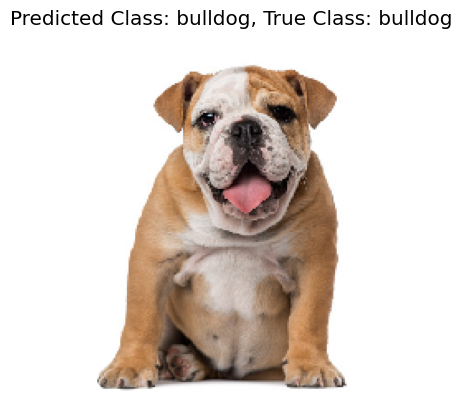

In [35]:
# Assuming you have already defined your model, class labels, and image path
class_labels = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
predict_and_display(model, class_labels, '/content/dog-breeds/bulldog/bulldog108.jpg', true_class='bulldog')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


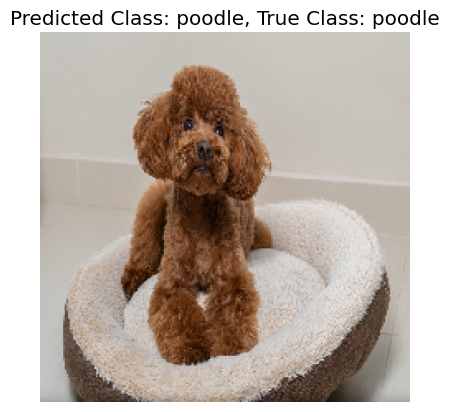

In [36]:
predict_and_display(model, class_labels, '/content/dog-breeds/poodle/poodle116.jpg', true_class="poodle")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


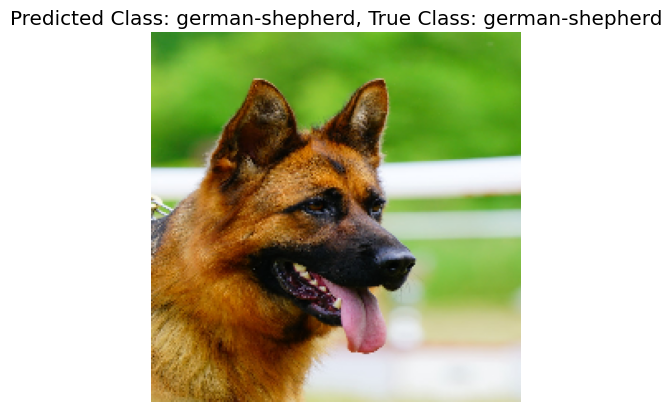

In [37]:
predict_and_display(model , class_labels, '/content/dog-breeds/german-shepherd/german-shepherd104.jpg', true_class='german-shepherd')